In [54]:
## Dataset Things
from data.volumes import Volume, Page, Line
from data.graphset import Graphset
from data.graph_sampler import AttributeSampler
from data.ced_dataset import CEDDataset
from data.esposalles_dataset import EsposallesDataset
from data.iam_dataset import IAMDataset
import data.volumes as dv

## Model Things
from models import visual_encoders as VE



### Utils
import utils 
import visualizations as visu

## Pipelines
import pipelines as pipes


## Common packages
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torchvision
from torch.optim import Adam


## Typing Packages
from typing import *

## Configuration Package
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra.utils import instantiate
from hydra import initialize, compose

## Experiment Tracking packages
import wandb
import tqdm


## Common packages
import os
import matplotlib.pyplot as plt
import pickle
import numpy as np
from beeprint import pp as bprint
import pdb
from math import ceil


device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
with initialize(version_base="1.3.2", config_path="./configs"):
    CFG = compose(config_name="pretrain", return_hydra_config=True)
    


In [56]:
CFG_MODELS = CFG.models
CFG_DATA = CFG.data
CFG_SETUP    = CFG.setup

In [57]:
#  ^ Hydra things
epochs = CFG_SETUP.configuration.epochs
batch_size = CFG_DATA.collator.batch_size
shuffle = CFG_DATA.collator.shuffle
checkpoint_name = CFG_MODELS.name_checkpoint
partitions_ratio = CFG_DATA.collator.partitions_ratio
# ^ 

In [58]:
# *Extracting the Datasets
means_width = []
means_heigth = []
list_of_datasets = []

for dataset_object in (CFG_DATA.datasets):
    data = instantiate(CFG_DATA.datasets[dataset_object])
    list_of_datasets.append(data)
    means_heigth.append(np.mean(data.line_heights))
    means_width.append(np.mean(data.line_widths))

standarized_width = ceil(np.mean(means_width))
standarized_height = ceil(np.mean(means_heigth))

for dts in list_of_datasets:
    dts.define_transforms((standarized_height, standarized_width))


if len(list_of_datasets) == 1:
    print("Only training with one Dataset")
    merged_dataset = list_of_datasets[-1]
else:
    merged_dataset = torch.utils.data.ConcatDataset(list_of_datasets)

collate_fn = list_of_datasets[0].collate_fn

generator = torch.Generator().manual_seed(2)
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(merged_dataset, partitions_ratio, generator=generator)
    # *

DOWNLOADING ESPOSALLES LINES


     100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

Only training with one Dataset


## Model

In [59]:
model = VE.LineAutoEncoder(cfg=CFG_MODELS.visual_encoder).to(device)


In [60]:
model_name = f"../checkpoints/{checkpoint_name}.pt"

model.load_state_dict(torch.load(model_name))
print("Model Loaded Succesfully Starting Finetunning")

Model Loaded Succesfully Starting Finetunning


In [61]:
model.eval()

LineAutoEncoder(
  (_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (_max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (_global_pooling): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (_init_convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (_output_convolution): Conv2d(128, 300, kernel_size=(3, 3), stride=(1, 1))
  (_max_unpooling): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (_global_max_unpool): MaxUnpool2d(kernel_size=(4, 4), stride=(4, 4), padding=(0, 0))
  (_output_deconvolution): ConvTranspose2d(300, 128, kernel_size=(3, 3), stride=(1, 1))
  (_init_deconvolution): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1))
)

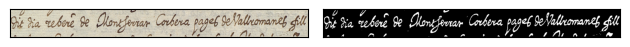

In [121]:
visu.plot([train_dataset[2][1],train_dataset[2][-1]])

In [137]:
data = train_dataset[2][1].unsqueeze(0)

In [138]:
data.shape

torch.Size([1, 3, 128, 1376])

In [139]:
reconstructed_image = model(data.cuda())

In [140]:
reconstructed_image.shape

torch.Size([1, 3, 128, 1376])

In [141]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

In [142]:
unnormalized = data.squeeze() * std + mean

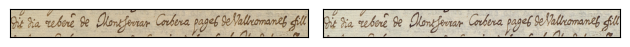

In [143]:
visu.plot([unnormalized, data.squeeze()])

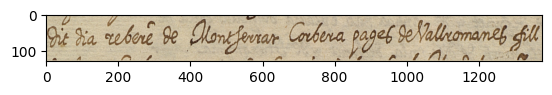

In [144]:
plt.imshow(unnormalized.permute(1, 2, 0))
plt.show()

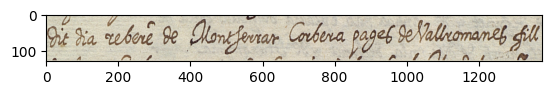

In [145]:
plt.imshow(data.squeeze().permute(1, 2, 0))
plt.show()

In [148]:
reconstructed_image

tensor([[[[0.8802, 0.8791, 0.9038,  ..., 0.9747, 0.9911, 0.9109],
          [0.8010, 0.7773, 0.9114,  ..., 0.9961, 1.0384, 0.9954],
          [0.8183, 0.9174, 1.1308,  ..., 1.1133, 1.1415, 1.0908],
          ...,
          [0.9120, 0.9509, 1.0942,  ..., 1.2257, 1.2553, 1.0392],
          [0.9210, 0.9200, 1.0305,  ..., 1.1773, 1.2111, 1.0325],
          [0.8786, 0.8862, 0.9790,  ..., 0.9560, 1.0073, 0.9714]],

         [[0.7239, 0.7289, 0.7594,  ..., 0.8373, 0.8534, 0.7624],
          [0.6407, 0.6298, 0.7884,  ..., 0.8719, 0.9202, 0.8687],
          [0.6647, 0.7968, 1.0387,  ..., 1.0076, 1.0401, 0.9748],
          ...,
          [0.7631, 0.8272, 0.9907,  ..., 1.1291, 1.1646, 0.9156],
          [0.7716, 0.7867, 0.9174,  ..., 1.0776, 1.1115, 0.9096],
          [0.7248, 0.7461, 0.8516,  ..., 0.8225, 0.8775, 0.8322]],

         [[0.4676, 0.4797, 0.5047,  ..., 0.5785, 0.5970, 0.5042],
          [0.3920, 0.3927, 0.5432,  ..., 0.6140, 0.6722, 0.6129],
          [0.4139, 0.5465, 0.7789,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


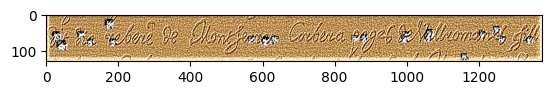

In [149]:
plt.imshow(reconstructed_image.detach().squeeze().cpu().permute(1, 2, 0))
plt.show()

In [150]:
r = reconstructed_image.detach().squeeze().cpu()
r = ((r*std + mean)*255).type(torch.uint8)

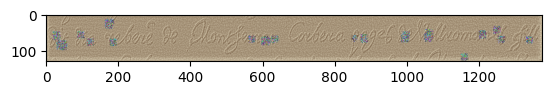

In [151]:
plt.imshow(r.permute(1, 2, 0))
plt.show()